In [4]:
#pip install netCDF4

In [1]:
#pip install tqdm

In [2]:
#pip install h5py

In [16]:
#load all the required libraries
import netCDF4 as nc
import glob
import pickle 
import numpy as np
import random
from tqdm import tqdm  
import pandas as pd
import datetime as datetime
import gc
import os
import h5py
from scipy.stats import pearson3, norm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [4]:
#load the new data

files_list = sorted(glob.glob('C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/Rainfall/*.nc4'))

In [5]:
files_list[0]

'C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/Rainfall\\3B-DAY.MS.MRG.3IMERG.20200801-S000000-E235959.V06.nc4.SUB.nc4'

In [11]:
# Open the .nc4 file
file_path = files_list[0]
dataset = nc.Dataset(file_path)

dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    BeginDate: 2020-08-01
    BeginTime: 00:00:00.000Z
    EndDate: 2020-08-01
    EndTime: 23:59:59.999Z
    FileHeader: StartGranuleDateTime=2020-08-01T00:00:00.000Z;
StopGranuleDateTime=2020-08-01T23:59:59.999Z
    InputPointer: 3B-HHR.MS.MRG.3IMERG.20200801-S000000-E002959.0000.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S003000-E005959.0030.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S010000-E012959.0060.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S013000-E015959.0090.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S020000-E022959.0120.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S023000-E025959.0150.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S030000-E032959.0180.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S033000-E035959.0210.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S040000-E042959.0240.V06B.HDF5;3B-HHR.MS.MRG.3IMERG.20200801-S0430

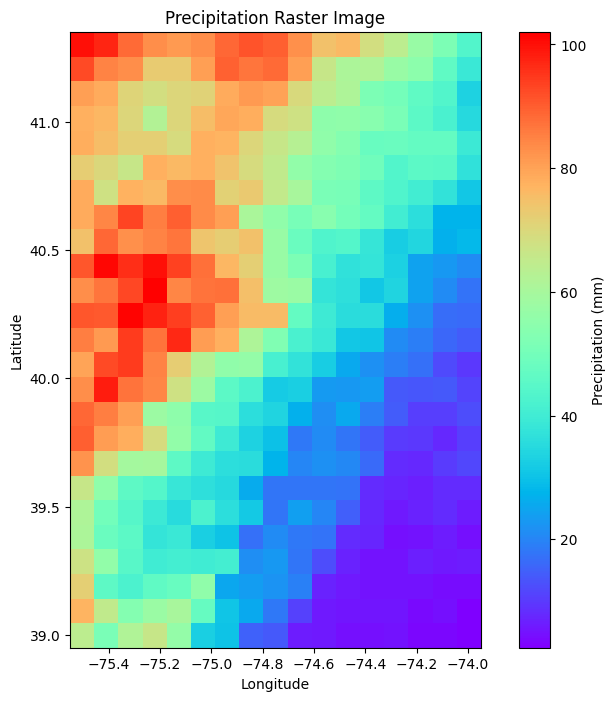

In [15]:
dataset = nc.Dataset(files_list[3])

# Read the variable
precipitation = dataset.variables['precipitationCal'][:]

# Get the longitude and latitude values
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# Create a grid of longitude and latitude values
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plot the raster image
plt.figure(figsize=(10, 8))
plt.imshow(precipitation[0].T, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='rainbow')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation Raster Image')
plt.show()

In [19]:
# Define the coordinates in New Jersey as a DataFrame
nj_coordinates_df = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Temp/latlong_NJ_degrees.csv")
nj_coordinates_df.head()

,Unnamed: 0,Center_Latitude,Center_Longitude
0,0,41.416894,-74.954401
1,1,41.412650,-74.956148
2,2,41.408405,-74.957895
3,3,41.404161,-74.959642
4,4,41.399917,-74.961389


In [25]:
import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# Open the netCDF file
dataset = nc.Dataset(files_list[3])

# Read the variable
precipitation = dataset.variables['precipitationCal'][:]

# Get the longitude and latitude values
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# Reshape the longitude and latitude arrays to have the same dimensions
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Create a KDTree from the reshaped longitude and latitude arrays
tree = cKDTree(np.column_stack((lon_2d.ravel(), lat_2d.ravel())))

# Define the coordinates in New Jersey as a DataFrame
nj_coordinates_df = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Temp/latlong_NJ_degrees.csv")

# Find the nearest grid points to the New Jersey coordinates
distances, indices = tree.query(np.column_stack((nj_coordinates_df['Center_Longitude'], nj_coordinates_df['Center_Latitude'])))

# Filter out indices that are out of bounds
valid_indices = np.logical_and(indices >= 0, indices < lon.shape[0] * lat.shape[0])

# Get the valid indices and rainfall values
valid_indices = valid_indices.nonzero()[0]
rainfall_values = precipitation.ravel()[indices[valid_indices]]

# Create a new DataFrame with the valid indices and rainfall values
nj_coordinates_df_filtered = nj_coordinates_df.loc[valid_indices].copy()
nj_coordinates_df_filtered['Rainfall'] = rainfall_values

nj_coordinates_df_filtered.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,17.378107
1,1,41.412650,-74.956148,17.378107
2,2,41.408405,-74.957895,17.378107
3,3,41.404161,-74.959642,17.378107
4,4,41.399917,-74.961389,17.378107


In [26]:
#drop unnamed
nj_coordinates_df_filtered = nj_coordinates_df_filtered.drop(columns="Unnamed: 0",axis=1)
nj_coordinates_df_filtered.head()

,Center_Latitude,Center_Longitude,Rainfall
0,41.416894,-74.954401,17.378107
1,41.412650,-74.956148,17.378107
2,41.408405,-74.957895,17.378107
3,41.404161,-74.959642,17.378107
4,41.399917,-74.961389,17.378107


In [27]:
nj_coordinates_df_filtered["Rainfall"].value_counts()

Rainfall
54.865696    1632
6.618120     1519
33.851585    1360
51.681637    1200
53.063381    1169
             ... 
5.328092        3
56.162056       2
57.512688       1
16.472694       1
85.460587       1
Name: count, Length: 350, dtype: int64

In [33]:
nj_coordinates_df_filtered["Rainfall"].min()

2.4855392

In [29]:
# Open the netCDF file
dataset = nc.Dataset("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/Rainfall/July_monthly.nc4")

dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    Original_Producer_Metadata_FileHeader: DOI=10.5067/GPM/IMERG/3B-MONTH/06;
DOIauthority=http://dx.doi.org/;
DOIshortName=3IMERGM;
AlgorithmID=3IMERGM;
AlgorithmVersion=3IMERGM_6.3;
FileName=3B-MO.MS.MRG.3IMERG.20200701-S000000-E235959.07.V06B.HDF5;
SatelliteName=MULTI;
InstrumentName=MERGED;
GenerationDateTime=2020-10-31T08:11:51.000Z;
StartGranuleDateTime=2020-07-01T00:00:00.000Z;
StopGranuleDateTime=2020-07-31T23:59:59.999Z;
GranuleNumber=;
NumberOfSwaths=0;
NumberOfGrids=1;
GranuleStart=;
TimeInterval=MONTH;
ProcessingSystem=PPS;
ProductVersion=V06B;
EmptyGranule=NOT_EMPTY;
MissingData=;

    Original_Producer_Metadata_FileInfo: DataFormatVersion=6a;
TKCodeBuildVersion=0;
MetadataVersion=6a;
FormatPackage=HDF5-1.8.9;
BlueprintFilename=GPM.V6.3IMERGM.blueprint.xml;
BlueprintVersion=BV_62;
TKIOVersion

In [31]:
#monthly
import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# Open the netCDF file
dataset = nc.Dataset("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/Rainfall/July_monthly.nc4")

# Read the variable
precipitation = dataset.variables['precipitation'][:]

# Get the longitude and latitude values
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# Reshape the longitude and latitude arrays to have the same dimensions
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Create a KDTree from the reshaped longitude and latitude arrays
tree = cKDTree(np.column_stack((lon_2d.ravel(), lat_2d.ravel())))

# Define the coordinates in New Jersey as a DataFrame
nj_coordinates_df = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/Temp/latlong_NJ_degrees.csv")

# Find the nearest grid points to the New Jersey coordinates
distances, indices = tree.query(np.column_stack((nj_coordinates_df['Center_Longitude'], nj_coordinates_df['Center_Latitude'])))

# Filter out indices that are out of bounds
valid_indices = np.logical_and(indices >= 0, indices < lon.shape[0] * lat.shape[0])

# Get the valid indices and rainfall values
valid_indices = valid_indices.nonzero()[0]
rainfall_values = precipitation.ravel()[indices[valid_indices]]

# Create a new DataFrame with the valid indices and rainfall values
nj_coordinates_df_monthly = nj_coordinates_df.loc[valid_indices].copy()
nj_coordinates_df_monthly['Rainfall'] = rainfall_values

nj_coordinates_df_monthly.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,0.25807
1,1,41.412650,-74.956148,0.25807
2,2,41.408405,-74.957895,0.25807
3,3,41.404161,-74.959642,0.25807
4,4,41.399917,-74.961389,0.25807


In [32]:
nj_coordinates_df_monthly["Rainfall"].value_counts()

Rainfall
0.221373    1632
0.439266    1519
0.272471    1360
0.227875    1200
0.198048    1169
            ... 
0.218351       3
0.263385       2
0.254638       1
0.256236       1
0.196409       1
Name: count, Length: 350, dtype: int64

In [34]:
nj_coordinates_df_monthly["Rainfall"].max()

0.4392661